# Clear-sky detection

    1) compute kt = I/Iclr  (Ineicheon model)  7:00-17:00 or theta <= 85deg
    2) 1 day = 40 points of kt 
    3) if majority of 40 points of kt >= THRESHOLD --> regard as clear-sky day  --> output = tentative clear-sky days 
    4) compute cosine similarity between Iclr and candidates in 3) 
    5) rank these cosine similarity scores ---> plot the XX best ones using visualization as complimentary
    6) group all those XX best ones (assume these XX ones are quite large and cover many stations) into each stations
    7) estimate TL for each station using LS 
    8) plot TL for all stations using heat map

# Import data

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression, HuberRegressor
import seaborn as sns
import scipy
from scipy.stats import gaussian_kde
import plotly.express as px

from SolarCalculator.clearskycal import calsolar

In [2]:
plant = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/plant_metadata.csv',
                   usecols = lambda column : column != 'Unnamed: 0')

In [3]:
measurment_GHI = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/ISL_jan2022_jun2023.csv',
           usecols = lambda column : column != 'Unnamed: 0',parse_dates = ['Datetime'])
measurment_GHI.rename(columns = {'measure_ghi':'I'}, inplace = True)
measurment_GHI = measurment_GHI.merge(plant[['site_name','lat','lng','alt']], on = 'site_name', how = 'left')
measurment_GHI.set_index('Datetime', inplace = True)
measurment_GHI['zna'] = calsolar.cal_dzna(measurment_GHI, measurment_GHI.lat.values, measurment_GHI.lng.values)
measurment_GHI['czna'] = np.cos(measurment_GHI.zna * np.pi / 180)
measurment_GHI['AM'] = calsolar.cal_dairmass(measurment_GHI, measurment_GHI.lat.values, measurment_GHI.lng.values)

TL_ee499 = 4.773765928887537
measurment_GHI['Iclr'] = calsolar.cal_dclearsky(measurment_GHI, measurment_GHI.lat.values, 
                                                measurment_GHI.lng.values, measurment_GHI.alt.values, TL = TL_ee499)
measurment_GHI['k'] = measurment_GHI.I/measurment_GHI.Iclr
measurment_GHI['date'] = measurment_GHI.index.date
measurment_GHI.replace([np.inf, -np.inf], np.NaN, inplace = True)
measurment_GHI.dropna(inplace = True)
measurment_GHI.index = measurment_GHI.index.tz_localize('Asia/Bangkok')

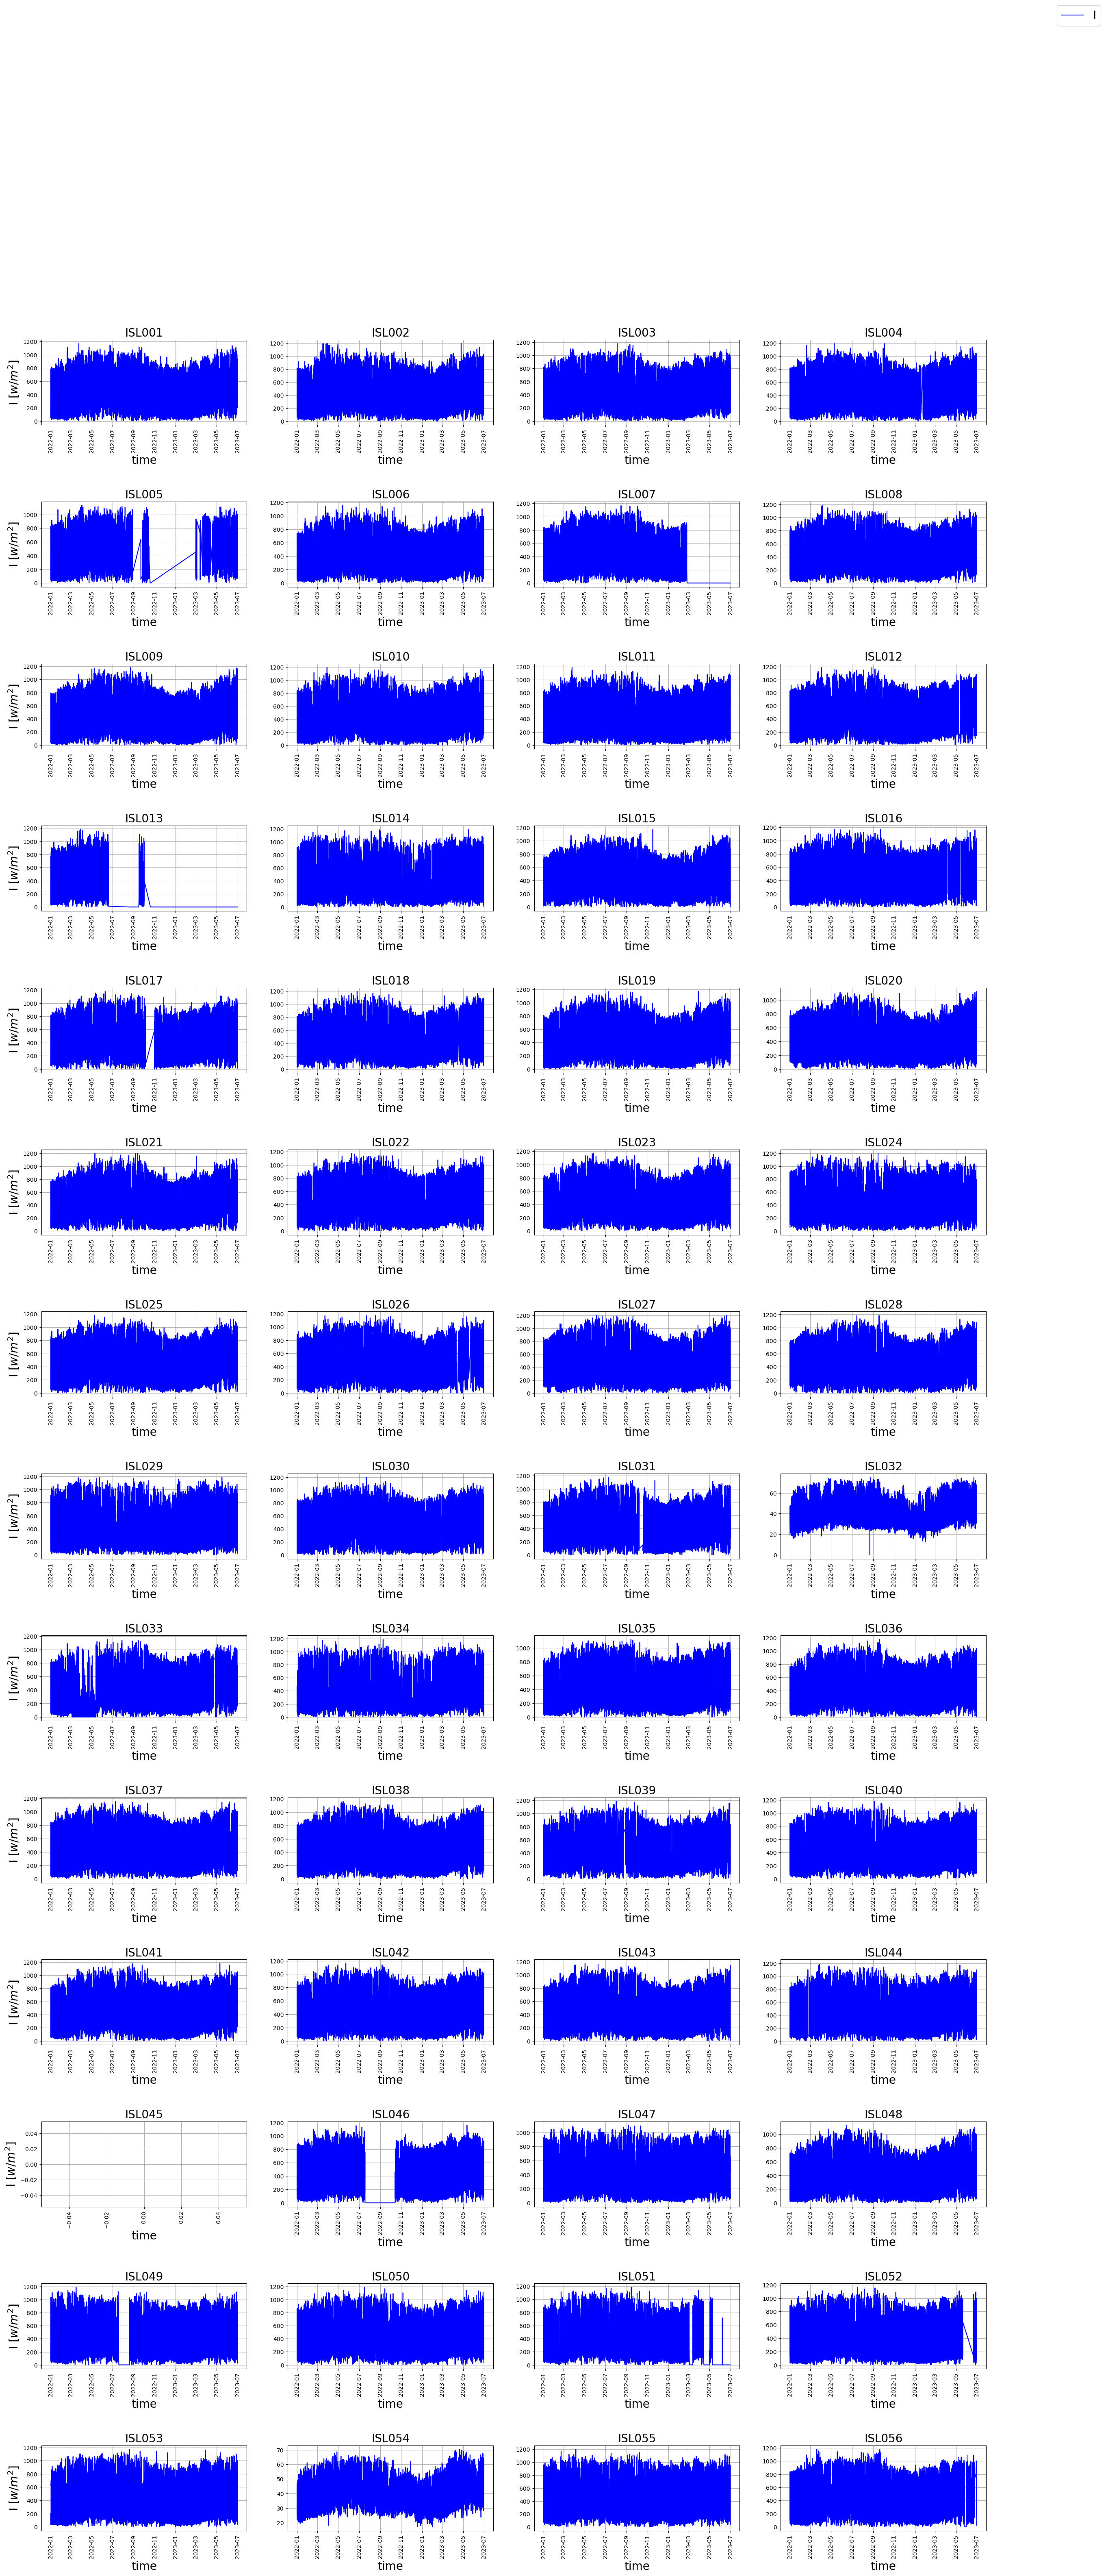

In [4]:
nrow = 14
ncol = 4

fig, ax = plt.subplots(nrow,ncol, figsize=(30,70))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow, ncol, k+1)
    ee1 = measurment_GHI[measurment_GHI.site_name == plant.site_name[k]]
    l1 = plt.plot(ee1.I, '-', color = 'blue')
    if k%4 == 0:
        plt.ylabel(r'I $[w/m^2]$', fontsize = 20)
    plt.xticks(rotation = 'vertical');
    plt.title(plant.site_name[k] ,fontsize = 20)
    plt.xlabel('time', fontsize = 20)
    plt.grid(True)
    plt.subplots_adjust(hspace = 0.9)

fig.legend(labels = 'I', fontsize = 20);
plt.show()

# Define functions

    Calculate cosine similarity with input is df_site : contain datetime_index and measurment GHI in each site, 
    threshold k and percentage of the point that greater than theshold k in a day.

In [5]:
def cosine_similarity(df_site, threshold_k, percent_majority) :
    date = [str(d) for d in df_site.groupby(by = df_site.index.date).mean().index]
    df_clear = []
    for k in range(len(date)) :
        count = 0
        ee1 = df_site.loc[date[k]]
        b = np.where(ee1.k > threshold_k , 1, 0)
        percent = b.sum()/len(ee1)    
        
        if percent > percent_majority and len(ee1) > 18:
            cosine = np.dot(ee1['I'],ee1['Iclr'])/(norm(ee1['I'])*norm(ee1['Iclr']))
            df_clear.append({'date' : date[k], 'cosine' : cosine}) 
            
    similarity = pd.DataFrame(df_clear).sort_values(by = 'cosine' , ascending = False)
    similarity.date = pd.to_datetime(similarity.date)
    return similarity

In [6]:
def ts_plot(similarity):
    clear_date = [str(d) for d in similarity.date.astype(str)]
    cosine = [ d for d in similarity.cosine]
    nrow = 10
    ncol = 4
    fig, ax = plt.subplots(nrow,ncol, figsize=(30,70))
    ax = ax.reshape(1,-1)[0]
    for k in range(len(ax)):
        plt.subplot(nrow, ncol, k+1)
        df_date = df_site.loc[clear_date[k]]
        l1 = plt.plot(df_date.I, '-x', color = 'black')
        l2 = plt.plot(df_date.Iclr, '-o', color = 'red')
        if k%4 == 0:
            plt.ylabel(r'I $[w/m^2]$', fontsize=20)
        plt.xticks(rotation = 'vertical');
        cos = round(cosine[k],5)
        plt.title(clear_date[k] + '\n cosine : '+ str(cos),fontsize=20)
        plt.xlabel('time',fontsize=20)
        plt.grid(True)
        plt.subplots_adjust(hspace=0.9)
    fig.legend(labels=['I','Iclr'],fontsize=20);    

In [7]:
def cal_TL(df, huber_epsilon):
    df = df[df.I > 0]
    I0 = 1366.1
    h = plant.alt[site-1]
    f1 = math.exp(-h/8000);
    f2 = math.exp(-h/1250);
    a1 = (h*5.09e-5) + 0.868;
    a2 = (h*3.92e-5) + 0.0387;
    df['y'] =  (f1 - f2)*a2*df['AM'] + (np.log(df['I'] / (a1 * I0 * df['czna'])))
    df['x'] = - a2 * f2 * df['AM']

    linear = LinearRegression()
    linear.fit(df.x.values.reshape(-1, 1) , df.y.values)
    huber = HuberRegressor(epsilon = huber_epsilon )
    huber.fit(df.x.values.reshape(-1, 1) , df.y.values)
    TL_linear = linear.coef_[0]
    TL_huber = huber.coef_[0]
    
    yhat_linear = linear.predict(df.x.values.reshape(-1, 1))
    yhat_huber = huber.predict(df.x.values.reshape(-1, 1))

    plt.scatter(df['x'].values, df['y'].values, s = 10)
    plt.plot(df['x'].values, yhat_linear,'-', color = 'red')
    plt.plot(df['x'].values, yhat_huber,'-', color = 'green')
    plt.grid(True)
    TL_lin = f"TL_linear = {linear.coef_[0]:.6f}"
    TL_hub = f"TL_huber = {huber.coef_[0]:.6f}"
    plt.text(0, 0, TL_lin, fontsize=10, color='red')
    plt.text(0, -0.1, TL_hub, fontsize=10, color='green')
    return df, TL_linear, TL_huber
    

In [8]:
def update_Iclr(df_site, old_TL, new_TL) :
    old_Iclr = calsolar.cal_dclearsky(df_site, plant.lat[site-1], plant.lng[site-1], 
                                                 plant.alt[site-1] , old_TL)
    new_Iclr = calsolar.cal_dclearsky(df_site, plant.lat[site-1], plant.lng[site-1], 
                                                 plant.alt[site-1] , new_TL)
    df_site = df_site.copy()
    df_site.loc[df_site['Iclr'].eq(old_Iclr), 'Iclr'] = new_Iclr
    return df_site

# visualize in each site

In [9]:
site = 30
threshold_k = 0.90
percent_majority = 0.80
df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[site-1])]

In [10]:
similarity = cosine_similarity(df_site, threshold_k = threshold_k, percent_majority = percent_majority)
print('The number of pass criterion days =',len(similarity),'days')
similarity

The number of pass criterion days = 113 days


date    cosine
96  2023-02-25  0.999441
81  2023-01-23  0.999394
100 2023-03-08  0.999271
44  2022-10-18  0.999193
95  2023-02-24  0.999167
..         ...       ...
40  2022-08-14  0.990482
31  2022-04-15  0.989642
9   2022-01-17  0.989013
105 2023-04-24  0.988249
33  2022-04-23  0.982182

[113 rows x 2 columns]

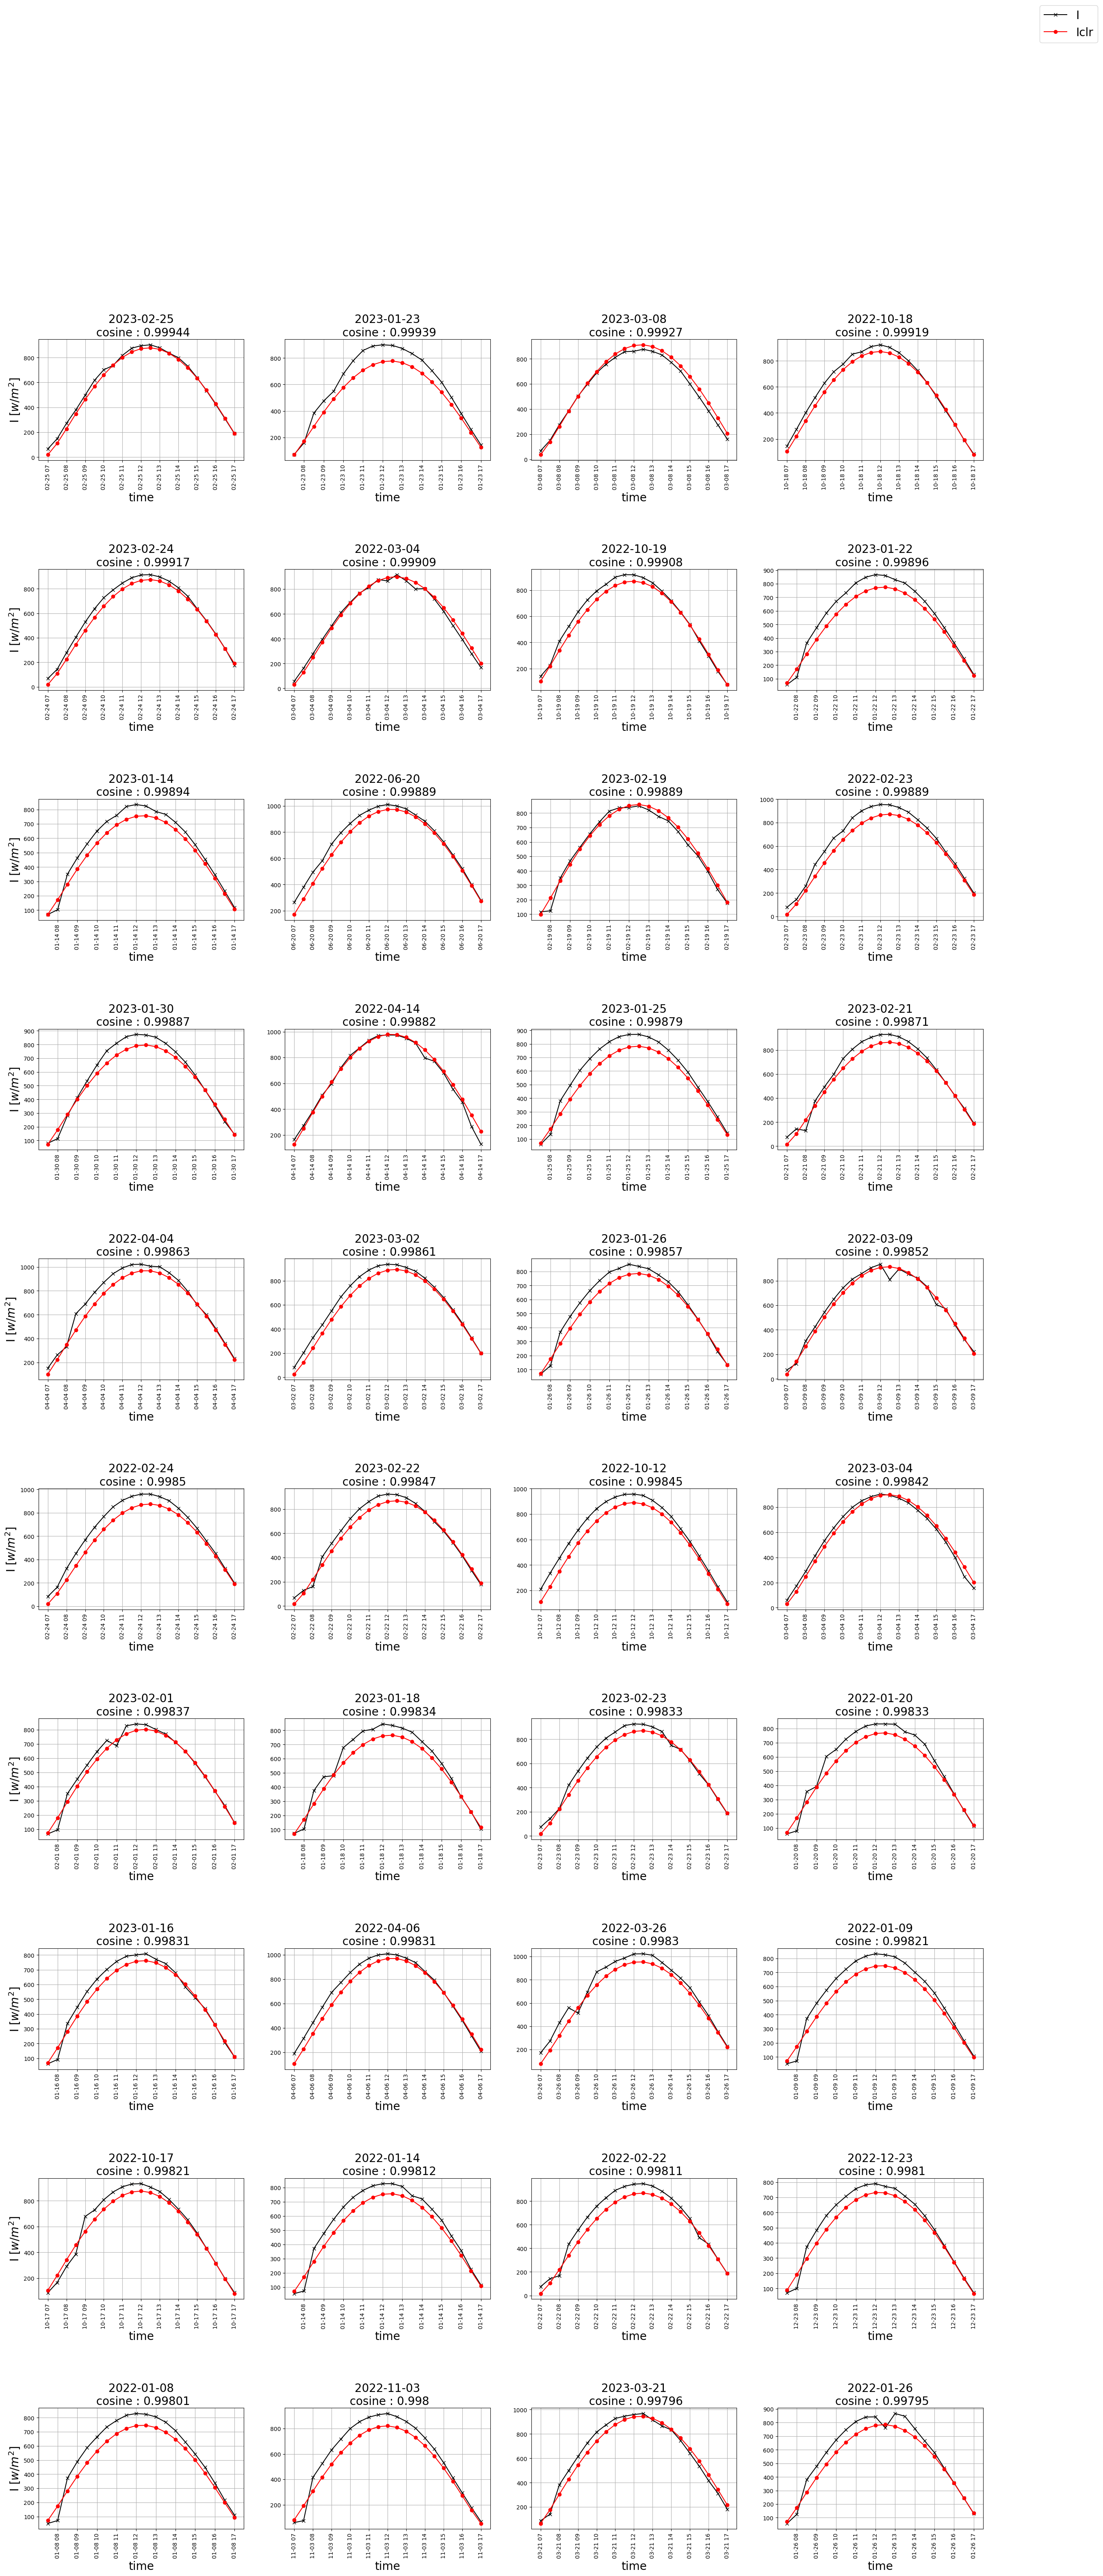

In [11]:
ts_plot(similarity)

(2.7069621567098143, 3.6777281017071517)

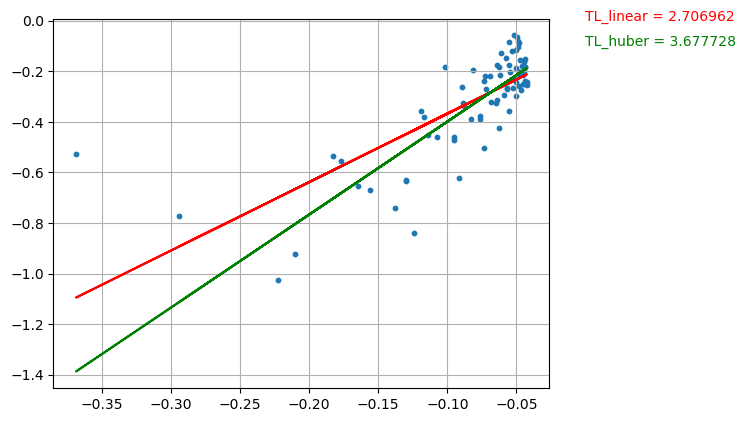

In [13]:
#Calculate TL by using regression.

threshold_cosine = 0.99917
clearday = similarity[similarity.cosine >= threshold_cosine]

df = df_site[np.isin(df_site.index.date, clearday.date.dt.date.to_list())]
df, TL_linear, TL_huber = cal_TL(df, huber_epsilon = 1)
TL_linear,TL_huber

In [14]:
df_site = update_Iclr(df_site, TL_ee499, TL_huber)
similarity2 = cosine_similarity(df_site, threshold_k = threshold_k, percent_majority = percent_majority)
print('The number of pass criterion days =',len(similarity2),'days')
similarity2

The number of pass criterion days = 113 days


date    cosine
96  2023-02-25  0.999544
95  2023-02-24  0.999279
44  2022-10-18  0.999246
36  2022-06-20  0.999199
81  2023-01-23  0.999166
..         ...       ...
31  2022-04-15  0.990252
60  2022-12-19  0.989458
9   2022-01-17  0.988947
105 2023-04-24  0.987580
33  2022-04-23  0.982057

[113 rows x 2 columns]

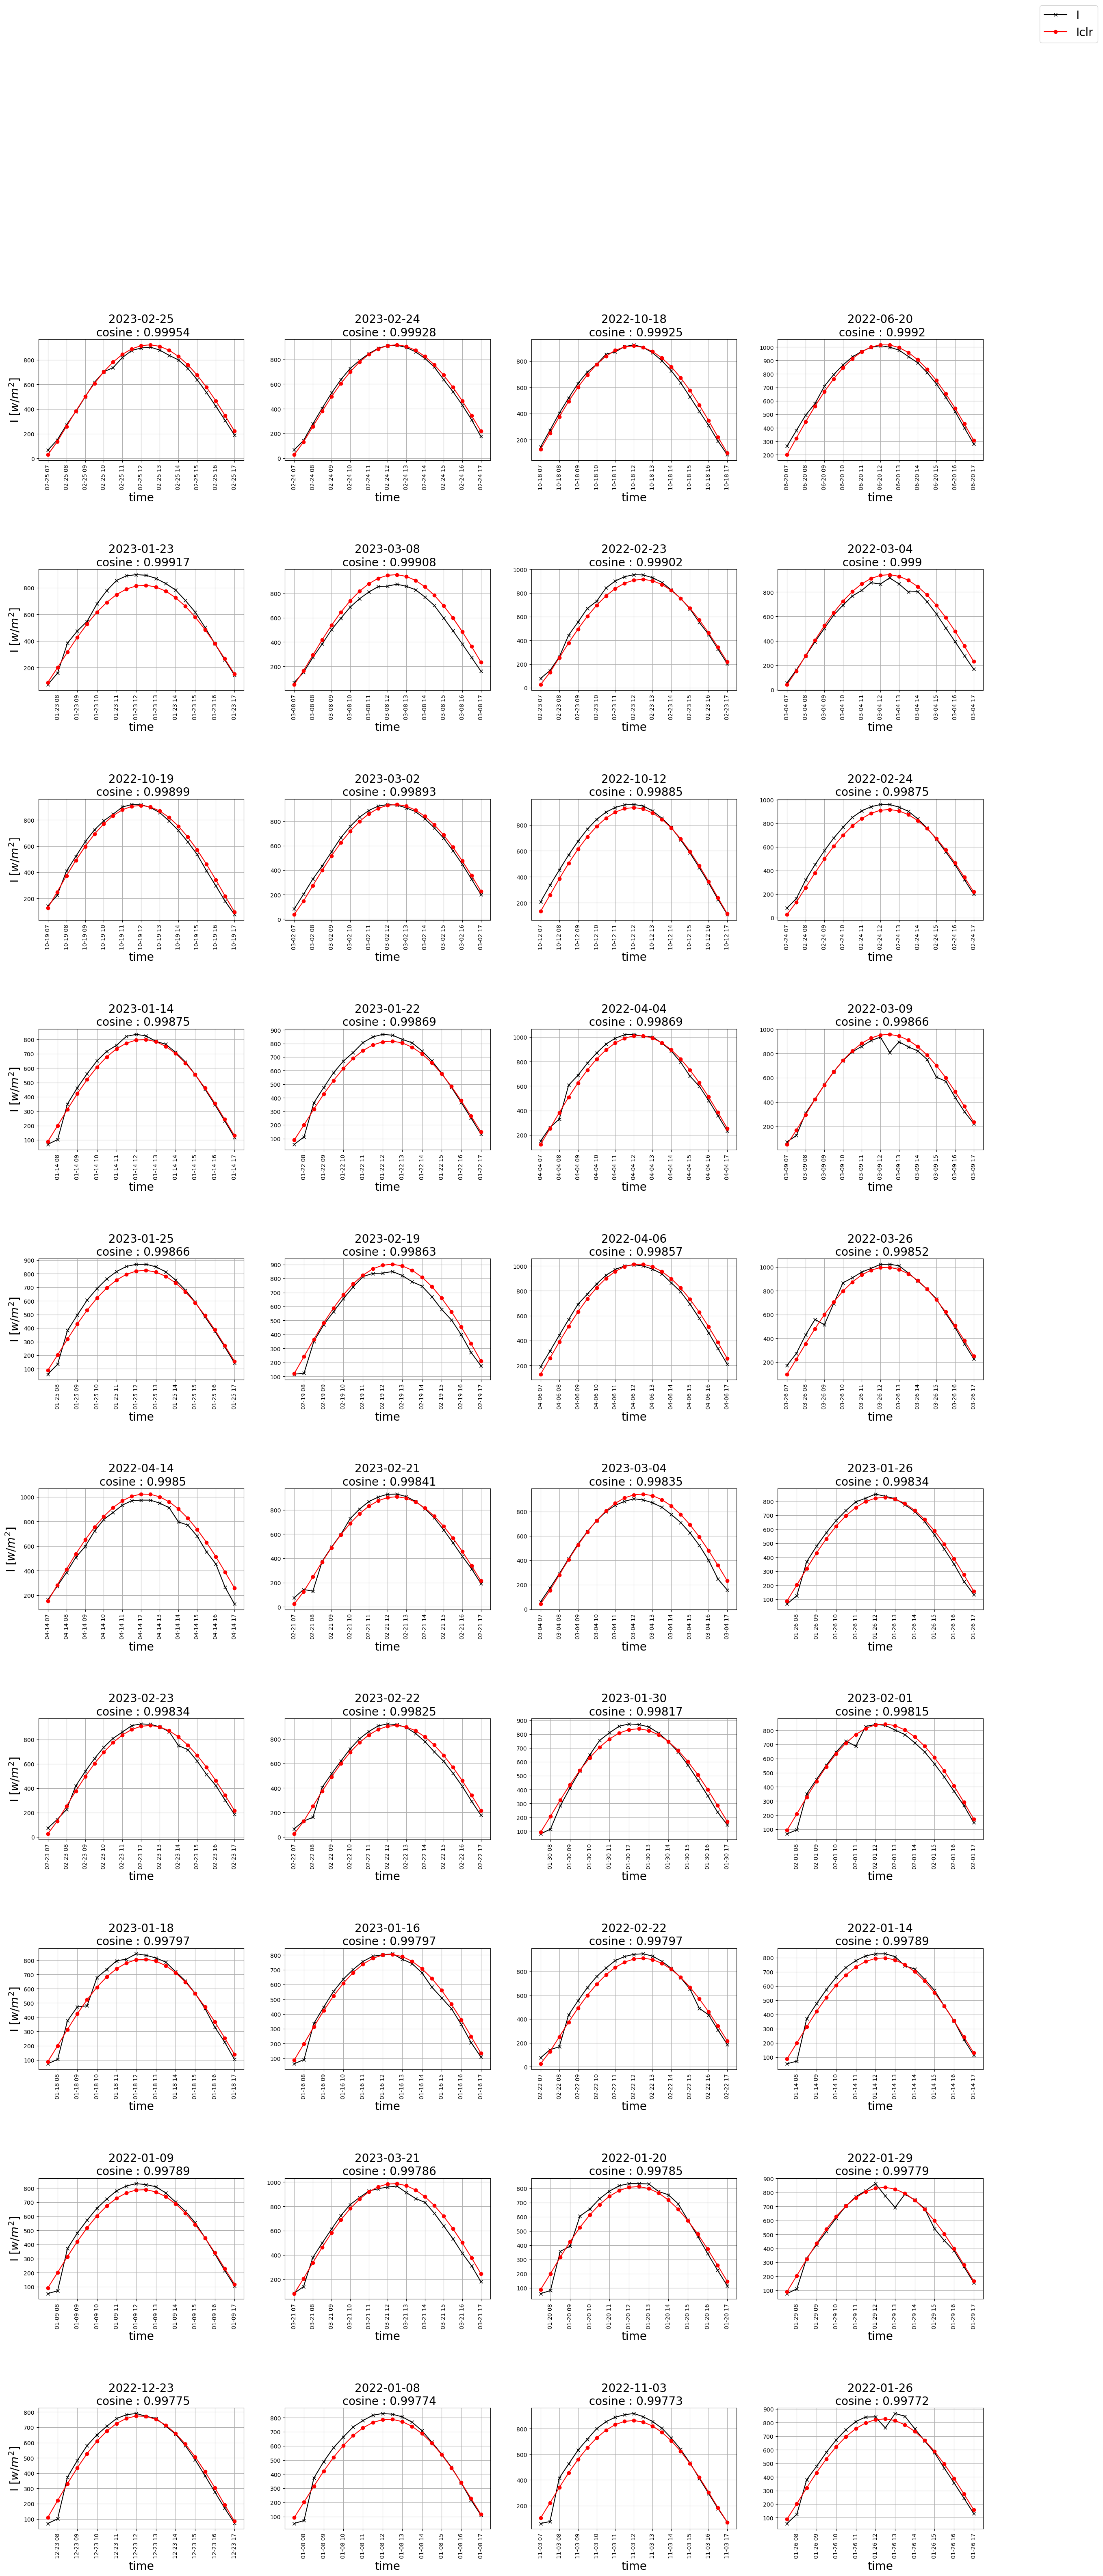

In [15]:
ts_plot(similarity2)

(1.8044636317614597, 2.5802471440999177)

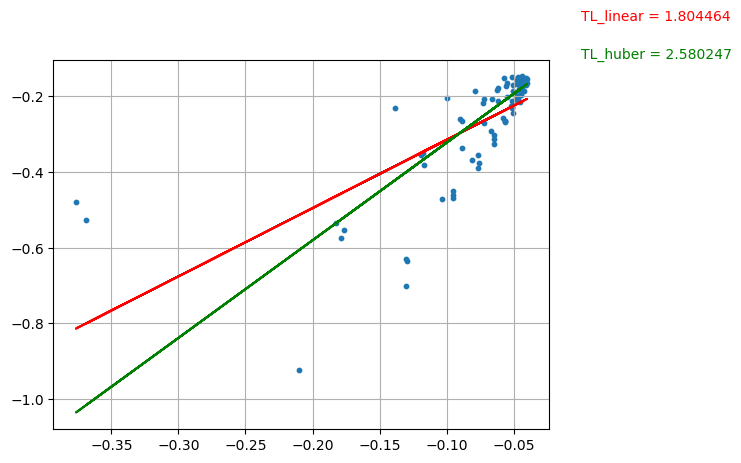

In [16]:
#Calculate TL by using  regression.

threshold_cosine = 0.99917
clearday = similarity2[similarity2.cosine >= threshold_cosine]

df = df_site[np.isin(df_site.index.date, clearday.date.dt.date.to_list())]
df, TL_linear2, TL_huber2 = cal_TL(df, 1)
TL_linear2, TL_huber2

In [17]:
df_site = update_Iclr(df_site, TL_huber, TL_huber2)
similarity3 = cosine_similarity(df_site, threshold_k = threshold_k, percent_majority = percent_majority)
print('The number of pass criterion days =',len(similarity3),'days')
similarity3

The number of pass criterion days = 113 days


date    cosine
96  2023-02-25  0.999408
36  2022-06-20  0.999328
95  2023-02-24  0.999147
97  2023-03-02  0.999026
44  2022-10-18  0.999017
..         ...       ...
53  2022-11-28  0.990034
9   2022-01-17  0.988536
60  2022-12-19  0.987904
105 2023-04-24  0.986681
33  2022-04-23  0.981717

[113 rows x 2 columns]

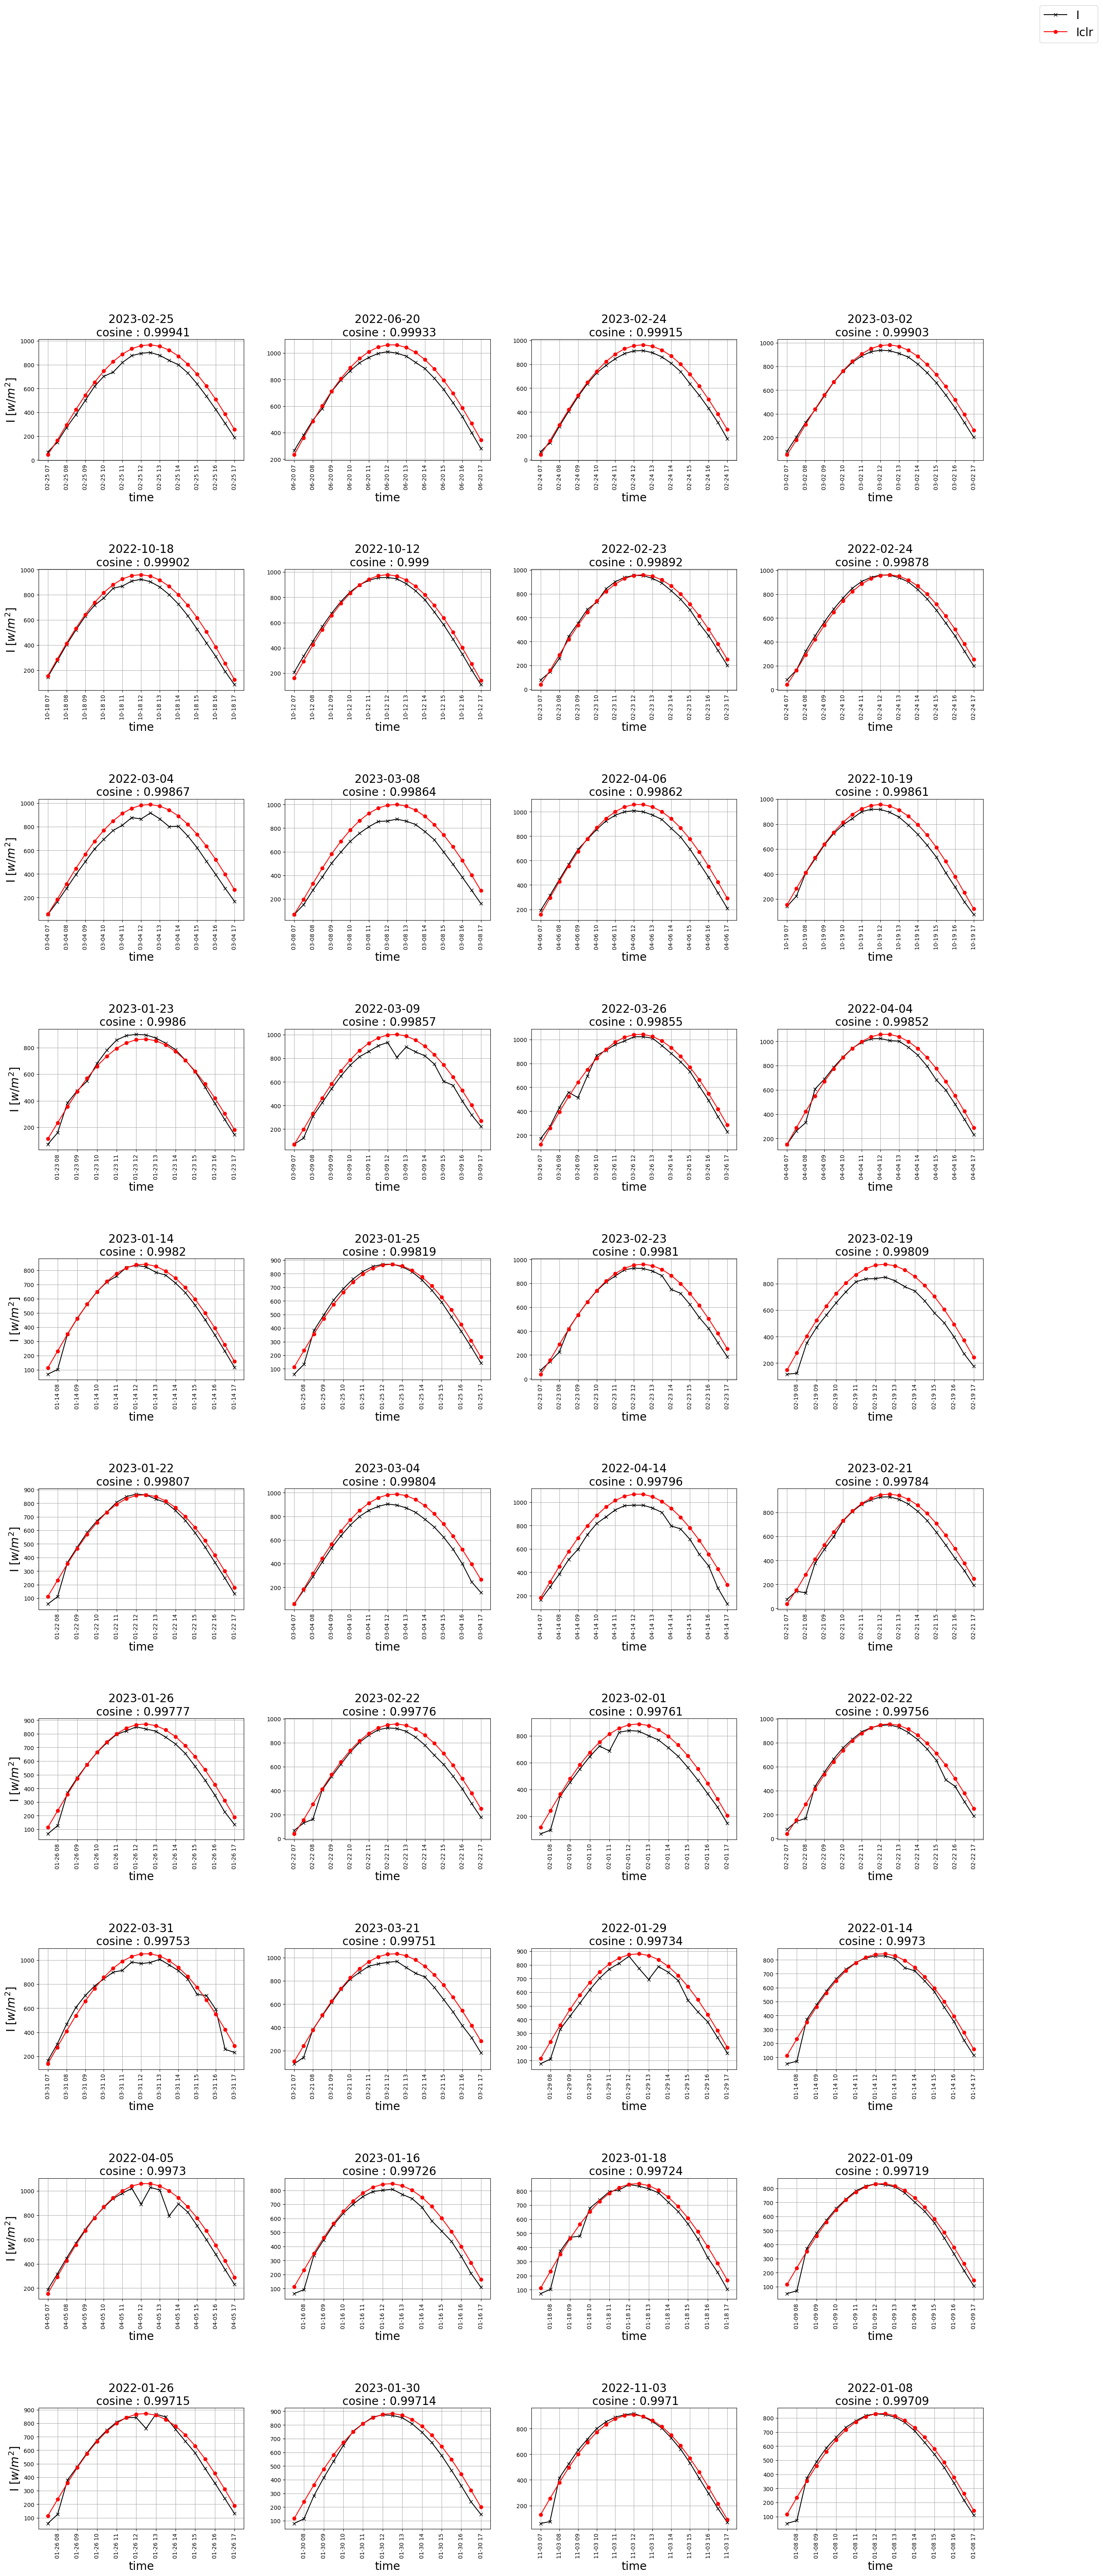

In [18]:
ts_plot(similarity3)

(1.5133200124610444, 2.6231251619609206)

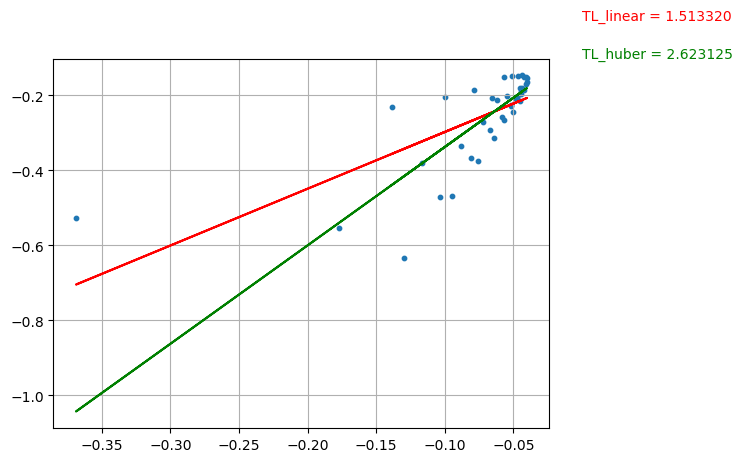

In [19]:
threshold_cosine = 0.99917
clearday = similarity3[similarity3.cosine >= threshold_cosine]

df = df_site[np.isin(df_site.index.date, clearday.date.dt.date.to_list())]
df, TL_linear3, TL_huber3 = cal_TL(df, 1)
TL_linear3, TL_huber3

In [20]:
df_site = update_Iclr(df_site, TL_huber2, TL_huber3)
similarity4 = cosine_similarity(df_site, threshold_k = threshold_k, percent_majority = percent_majority)
print('The number of pass criterion days =',len(similarity4),'days')
similarity4

The number of pass criterion days = 113 days


date    cosine
96  2023-02-25  0.999418
36  2022-06-20  0.999326
95  2023-02-24  0.999158
44  2022-10-18  0.999032
97  2023-03-02  0.999027
..         ...       ...
53  2022-11-28  0.990066
9   2022-01-17  0.988559
60  2022-12-19  0.987973
105 2023-04-24  0.986721
33  2022-04-23  0.981735

[113 rows x 2 columns]

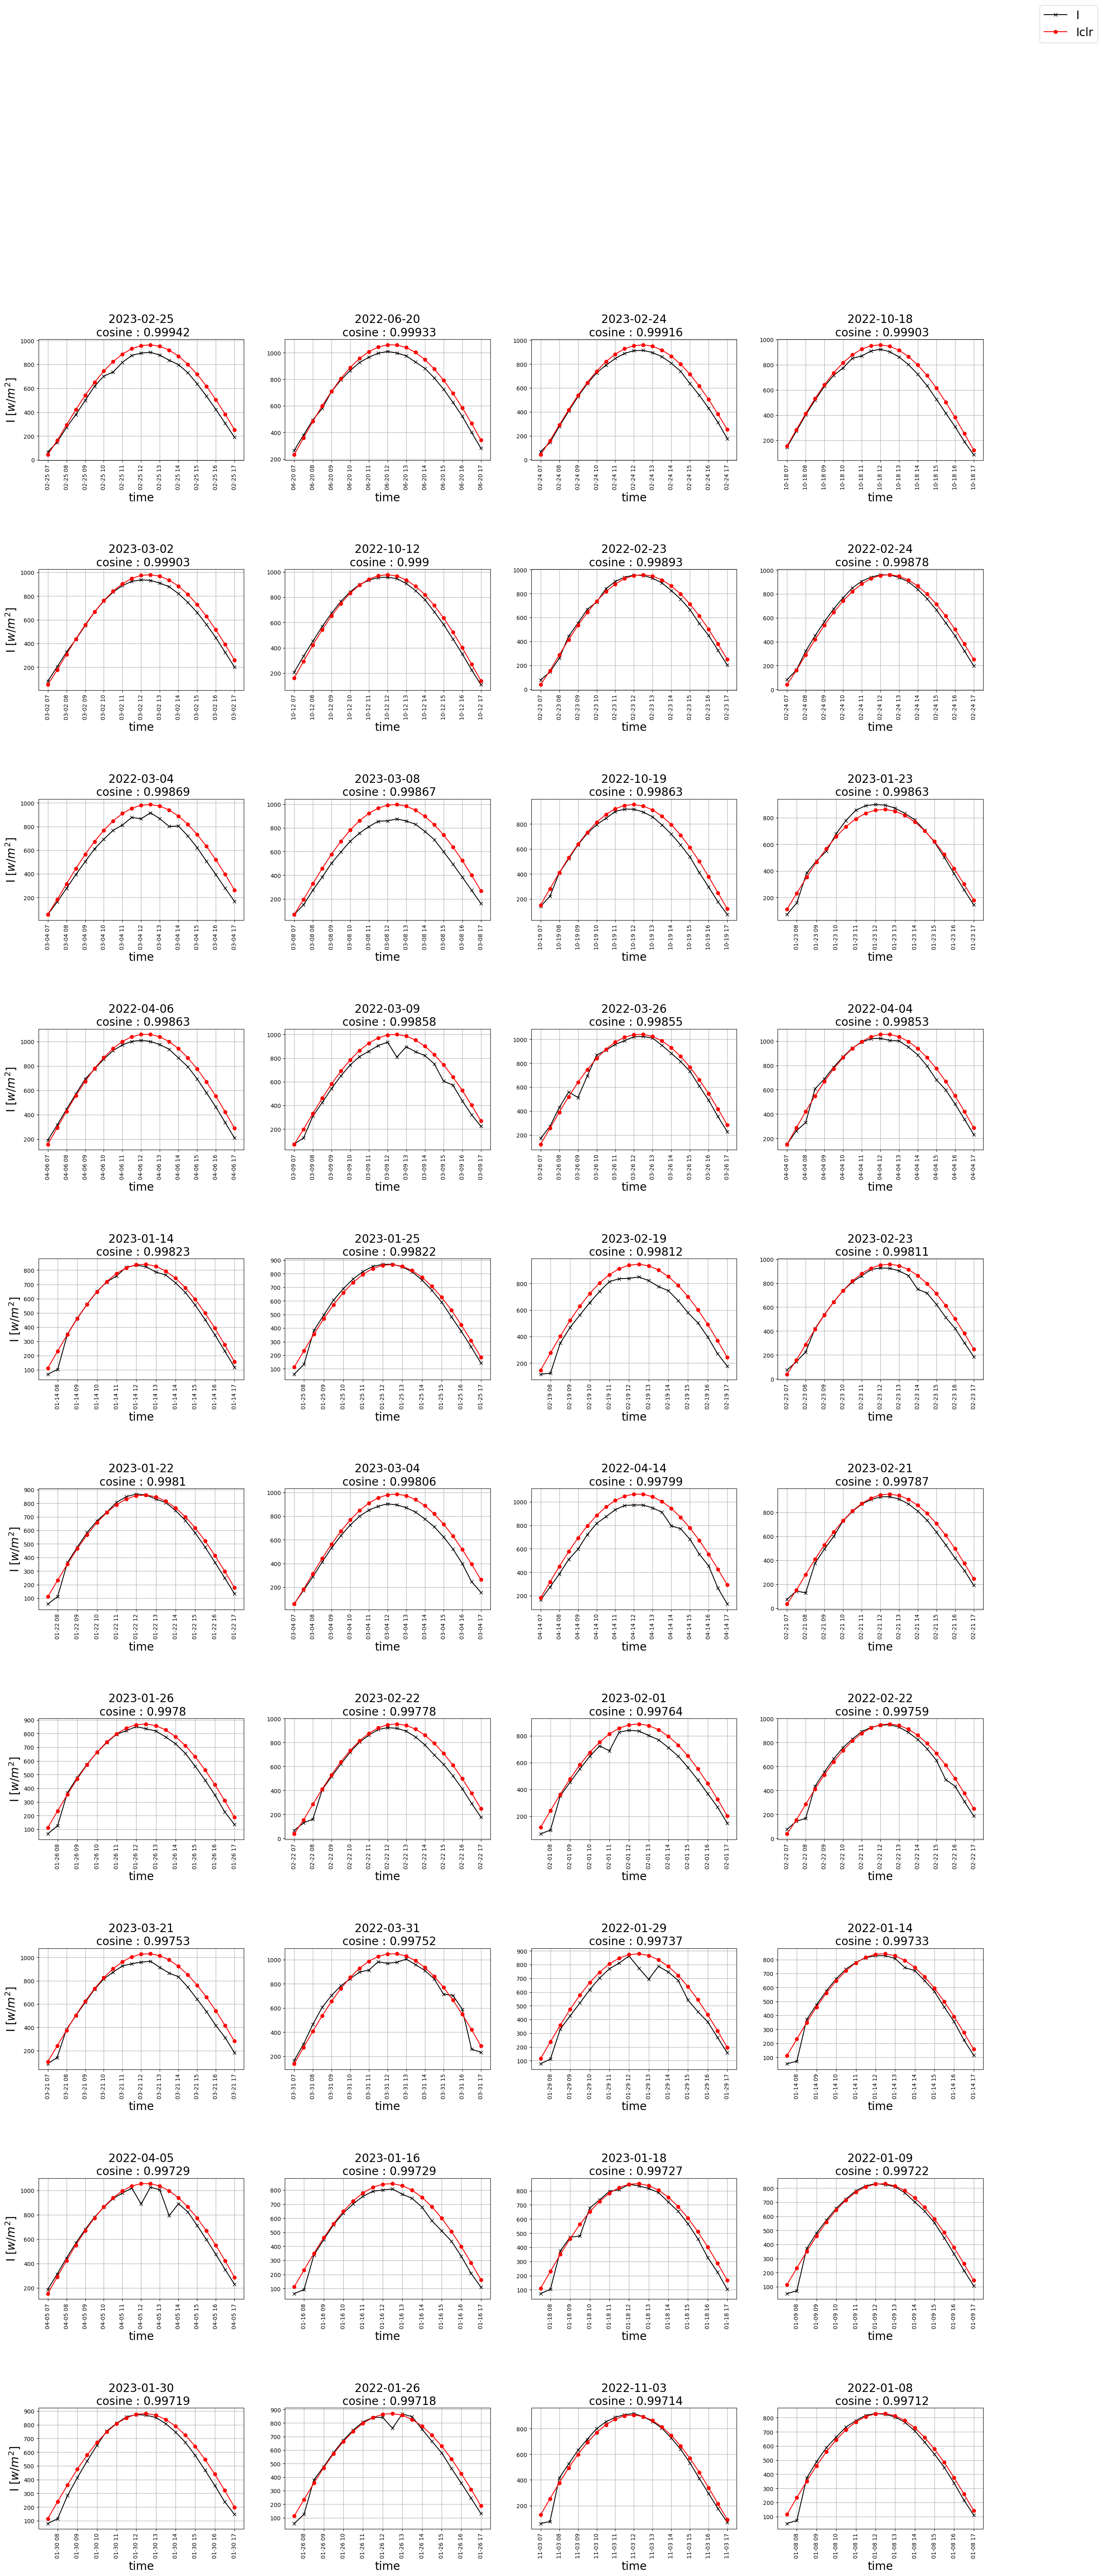

In [21]:
ts_plot(similarity4)

# Calculate TL all site

In [ ]:
def clearsky_detection(df, threshold_k, percent_majority, number_clearday) :
    TL_list = []
    TL_df = pd.DataFrame()
    for i in range(56):
        df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[i])]
        # site ISL045 don't have GHI and GHI in ISL045/032 is range (20-70 W/m2)
        if i == 31 or i == 44 or i == 53: 
            TL_list.append({'site_name':plant.site_name[i], 'lat' : plant.lat[i], 'lon' : plant.lng[i], 'TL' : 'NaN'})
            pass
        else :
            similarity = cosine_similarity(df_site, threshold_k, percent_majority)
            clearday = similarity[:number_clearday-1].copy()
            d = [str(d) for d in clearday.date]
            df = pd.DataFrame()
            for k in range(len(d)):
                df = pd.concat([df,df_site.loc[d[k]]])
            df = df[df.I > 0]
            I0 = 1366.1
            h = plant.alt[0]
            f1 = math.exp(-h/8000);
            f2 = math.exp(-h/1250);
            a1 = (h*5.09e-5) + 0.868;
            a2 = (h*3.92e-5) + 0.0387;
            df['y']= (f1 - f2)*a2*df['AM'] + np.log(df['I'] / (a1 * I0 * df['czna']))
            df['x']= - a2 * f2 * df['AM']

            model = LinearRegression()
            model.fit(df.x.values.reshape(-1, 1) , df.y.values)
            TL = model.coef_[0]
            TL_list.append({'site_name':plant.site_name[i], 'lat' : plant.lat[i], 'lon' : plant.lng[i], 
                            'alt' : plant.lat[i], 'criterion_pass' : len(similarity), 'TL' : TL})
            
            TL_df = pd.concat([TL_df, df])
    TL_all = LinearRegression()
    TL_all.fit(TL_df.x.values.reshape(-1, 1) , TL_df.y.values)
    TL56site = TL_all.coef_[0]

    df_TL = pd.DataFrame(TL_list)
    return df_TL, TL56site
    

In [ ]:
df_TL, TL56site = clearsky_detection(measurment_GHI, 
                                     threshold_k = 0.9, 
                                     percent_majority = 0.8, 
                                     number_clearday = 10)
print('TL all 56 sites = ',TL56site)
df_TL

In [ ]:
import folium
from folium.plugins import HeatMap

df = df_TL
df.dropna(inplace = True)
df_TL['scaled_TL'] = (df_TL.TL - df_TL.TL.min()) / (df_TL.TL.max() - df_TL.TL.min())

# Create a map centered on the first coordinate (you can adjust the coordinates and zoom level)
map_center = [df['lat'].iloc[45], df['lon'].iloc[45]]
map_zoom = 14
map_obj = folium.Map(location=map_center, zoom_start=map_zoom)

# Add markers for each coordinate with the TL value as a popup
for index, row in df.iterrows():
    latitude, longitude, altitude, tl_value, site = row['lat'], row['lon'], row['alt'], row['TL'], row['site_name']
    popup_text = f"Site: {site} " f"Alt: {altitude}"  f"\n TL: {round(tl_value,4)}"
    folium.Marker(location=[latitude, longitude], popup=popup_text).add_to(map_obj)

# Create a list of (latitude, longitude, weight) tuples for the HeatMap
heatmap_data = [[row['lat'], row['lon'], row['scaled_TL']] for index, row in df.iterrows()]

# Add HeatMap layer to the map
HeatMap(heatmap_data).add_to(map_obj)

# map_obj.save("map_with_markers_and_heatmap.html")
map_obj
